<a href="https://colab.research.google.com/github/AbigailDerton/titanic-ml/blob/main/Titanic_Survival_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster

Author: Abigail Derton ([LinkedIn](https://www.linkedin.com/in/abigail-derton/), [GitHub](https://github.com/AbigailDerton))

This notebook is my submission to the classic [Titanic: Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) competition on Kaggle. Using models from the scikit-learn library, I compare several machine learning approaches to predict which passengers survived the Titanic shipwreck.

The workflow is organized as follows:

1. Import required libraries and load the data

2. Explore and visualize key features

3. Build a data-cleaning and preprocessing pipeline

4. Train and tune machine learning models to predict survival

5. Evaluate model performance on unseen test data

##1. Import required libraries and load the data

Load required libraries:

In [27]:
import os # used to check/change working directory
import pandas as pd # for reading/manipulating pandas dataframes
import numpy as np # for getting unique values in a column
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
from pandas.plotting import scatter_matrix # for plotting every numerical attribute against every other numerical attribute

# Install libraries for data preprocessing class
from sklearn.impute import SimpleImputer # for median imputation (missing passenger ages)
from sklearn.preprocessing import OneHotEncoder # for encoding categorical variables
from sklearn.base import BaseEstimator, TransformerMixin # for custom data cleaning pipeline class
from sklearn.pipeline import Pipeline # Used to create a pipeline including custom data preprocessing class. this will be useful for hyperparameter tuning.

# Install libraries for ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # K-fold cross validation
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning

# Show plots inline:
%matplotlib inline

Load the data:

In [2]:
train_set = pd.read_csv("titanic_data/train.csv")
test_set = pd.read_csv("titanic_data/test.csv")

## 2. Explore and visualize key features

Look at first few rows of each dataframe and examine summary statistics:

In [3]:
print(train_set.head()) # look at the first few rows of data
print(train_set.info()) # look at data types and non-null counts
print(train_set.describe()) # statistical summaries of numerical columns
print(train_set.shape) # number of rows and columns

   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null  

In [4]:
print(test_set.head()) # look at the first few rows of data
print(test_set.info()) # look at data types and non-null counts
print(test_set.shape) # number of rows and columns

   PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None


The training set includes 12 features and 891 rows. The features Age, Cabin, and Embarked contain some null values. Approximately 38.4% of passengers survived, indicating a reasonably balanced target variable. The features Name, Sex, Ticket, Cabin, and Embarked are text/categorical and will need to be converted to numeric format before fitting machine learning models.

The test set does not include labels (Survived).

Examine the distribution of numeric features. Make sure to code sex as numeric so it can be included in the plots:

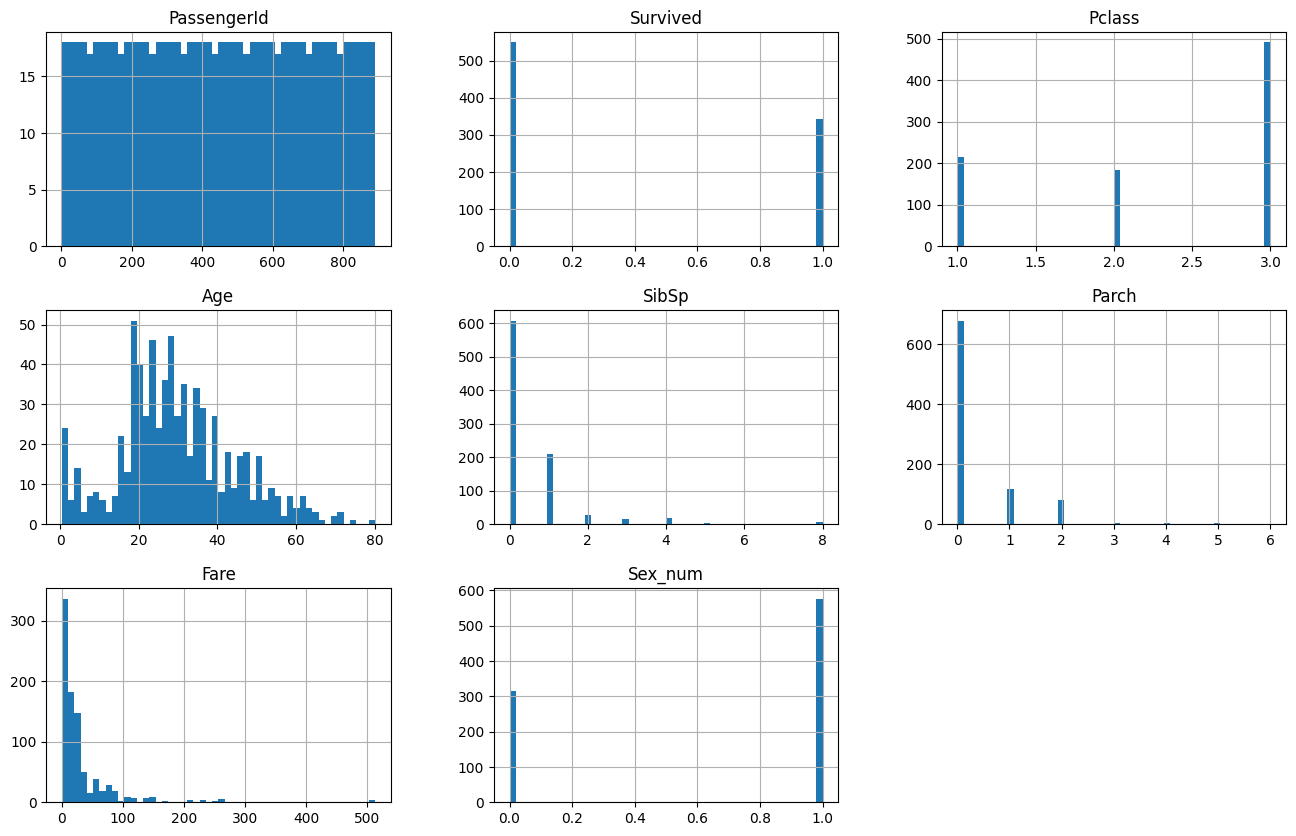

In [5]:
# create a numeric column for passenger sex
train_set["Sex_num"] = train_set["Sex"].map({"female":0, "male": 1})

# plot histograms of all numeric features
train_set.hist(bins=50, figsize=(16,10))
plt.show()

Examine the correlations between numeric features:

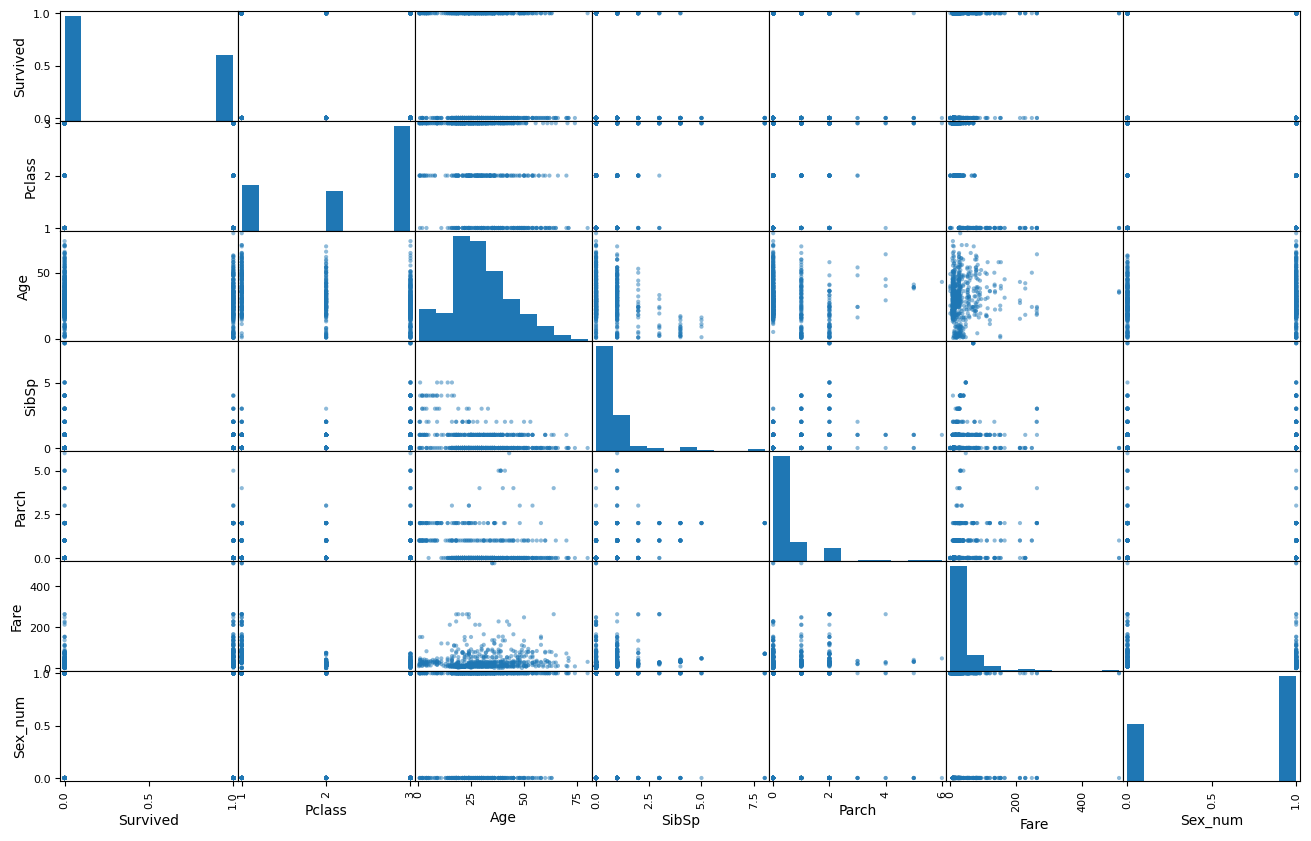

In [6]:
scatter_matrix(train_set[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_num"]], figsize=(16, 10))
plt.show()

The above scatter matrix did not reveal any strong correlations.

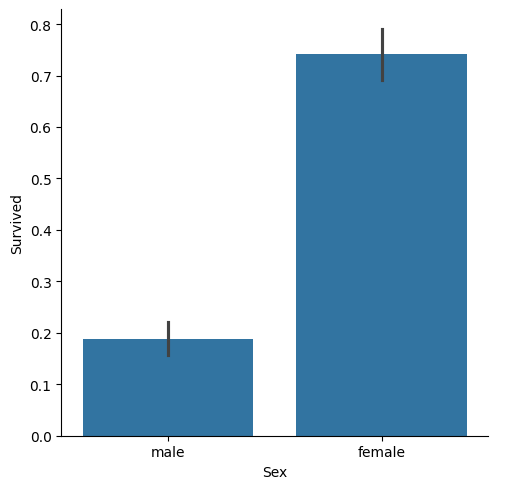

In [7]:
#sns.catplot(data=train_set, x="Sex", y="Survived", hue="Pclass", kind="bar")
sns.catplot(data=train_set, x="Sex", y="Survived", kind="bar")

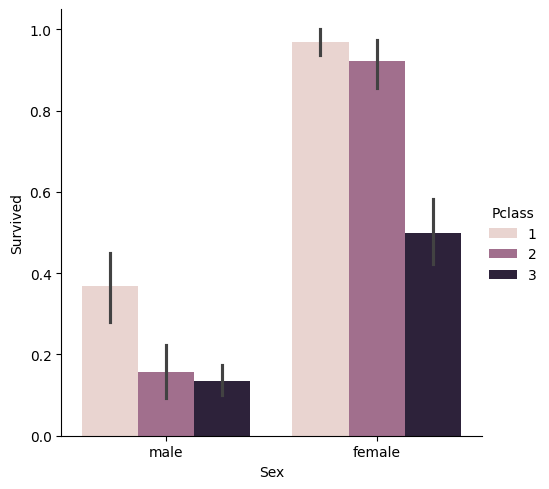

In [8]:
sns.catplot(data=train_set, x="Sex", y="Survived", hue="Pclass", kind="bar")

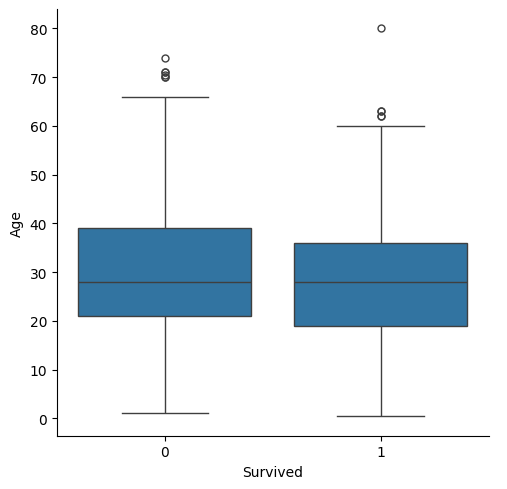

In [9]:
sns.catplot(data=train_set, x="Survived", y="Age", kind="box")

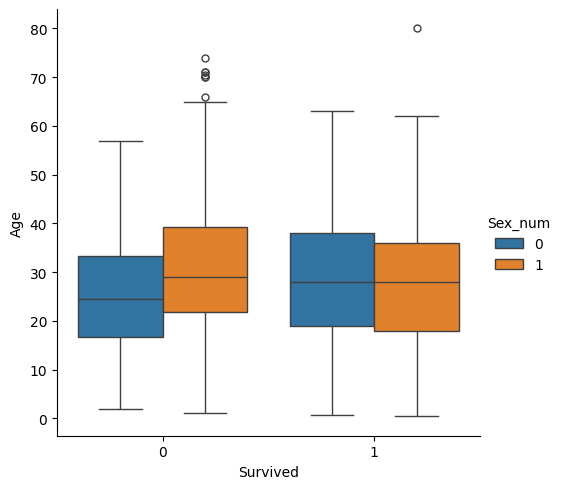

In [10]:
sns.catplot(data=train_set, x="Survived", y="Age", hue="Sex_num", kind="box")

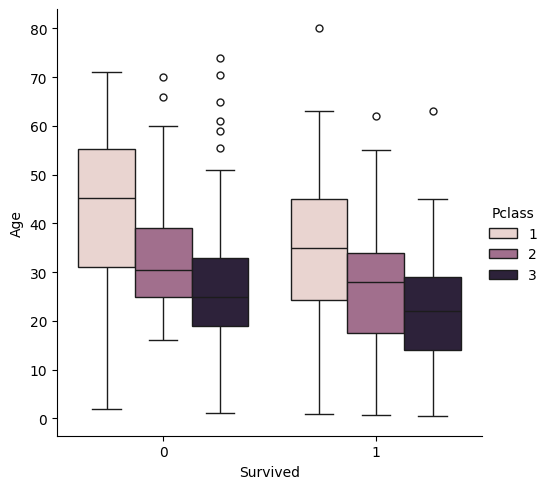

In [60]:
sns.catplot(data=train_set, x="Survived", y="Age", hue="Pclass", kind="box")

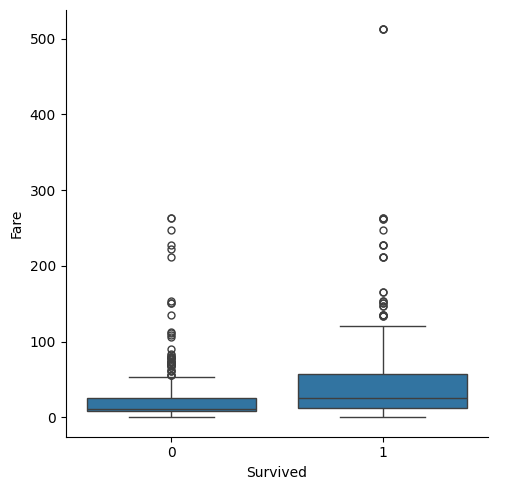

In [57]:
sns.catplot(data=train_set, x="Survived", y="Fare", kind="box")

<Axes: xlabel='Age', ylabel='Fare'>

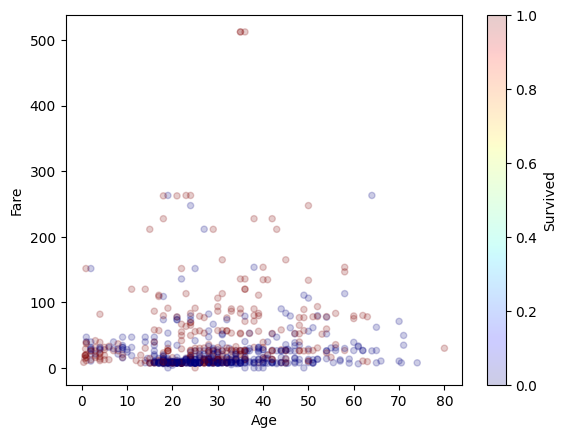

Sex is clearly an important indicator of survival. What about married status? Were married women more or less likely to survive than unmarried? We may be able to guess married status by looking for "Mrs." in the Name column

In [68]:
train_set["Name_lower"] = train_set["Name"].str.lower()
train_set["married_woman"] = train_set["Name_lower"].str.contains("mrs")
train_set["married_woman"].value_counts()

,count
married_woman,
False,762
True,129


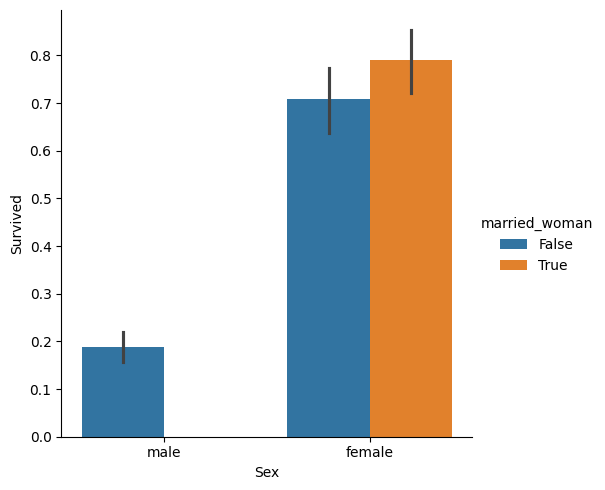

In [69]:
sns.catplot(data=train_set, x="Sex", y="Survived", hue="married_woman", kind="bar")

Married women had a slightly higher chance of survival compared to unmarried.

In [72]:
pd.set_option('display.max_rows', None)
print(train_set["Name"])

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

What about "Miss"?

In [77]:
train_set["Name_is_Miss"] = train_set["Name_lower"].str.contains("miss")
train_set["Name_is_Miss"].value_counts()

,count
Name_is_Miss,
False,709
True,182


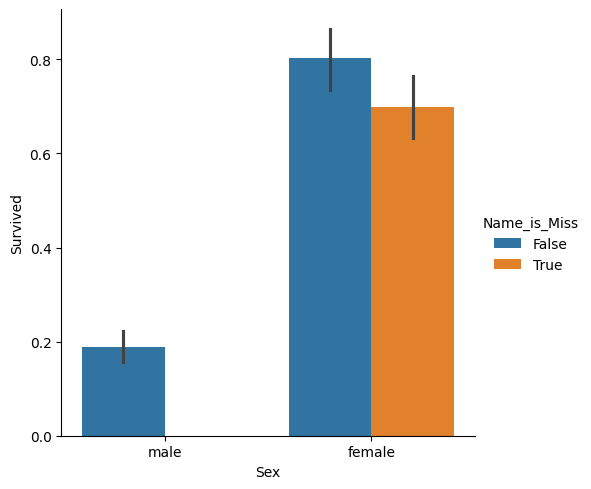

In [78]:
sns.catplot(data=train_set,kind="bar", x="Sex", y="Survived", hue="Name_is_Miss")

This seems no more informative than the married woman variable.

## 3. Build a data-cleaning and preprocessing pipeline

Build a pipeline that performs the following transformations:



*   Create a numerical Sex feature
*   Create a numerical married woman feature
*   Impute missing numeric features

*   Impute missing port of embarkation
*   One-hot encode port of embarkation

*   Drop features not intended for use in machine learning model







In [38]:
# Note: I included BaseEstimator in this custom class so that I'll automatically get two extra methods (get_params() and set_params()) which will be useful for hyperparameter tuning
# I also included TransformerMixin to get the fit_transform() method

class titanic_data_prep(BaseEstimator, TransformerMixin):
  def __init__(self, sex_3levels = True):
    """
    sex_3levels: if True (default), three indicator columns will be created indicating whether passenger is a married woman, an unmarried woman, or a man. If False, only one indicator variable will be created indicating whether passenger was male.
    """
    self.sex_3levels = sex_3levels

  def fit(self, X, y=None):
    return self # nothing else to do

  def transform(self, X):
    # define index (needed for merging)
    X.index = X["PassengerId"]

    # create a numeric column for passenger sex
    X["Sex_num"] = X["Sex"].map({"female":0, "male": 1})

    # create a numeric married woman feature
    X["Name_lower"] = X["Name"].str.lower()
    X["Married_woman"] = X["Name_lower"].str.contains("mrs").map({True:1, False:0})
    X["Man"] = X["Sex_num"]
    X["Unmarried_woman"] = -1*(X["Married_woman"] + X["Man"]) + 1

    # Define numeric and categorical columns
    if self.sex_3levels == True:
      X_num = X[["Pclass", "Married_woman", "Unmarried_woman", "Man", "Age", "SibSp", "Parch", "Fare"]]
    else:
      X_num = X[["Pclass", "Sex_num", "Age", "SibSp", "Parch", "Fare"]]

    X_cat = X[["Embarked"]]

    # Handle rows with missing values
    # Impute missing numeric features
    imputer = SimpleImputer(strategy="mean")
    imputer.fit(X_num)
    X_array = imputer.transform(X_num) # this is a plain NumPy array
    X_num = pd.DataFrame(X_array, columns = X_num.columns, index = X_num.index) # convert X_num back to a pandas dataframe

    # Impute missing port of embarkation
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(X_cat)
    X_array = imputer.transform(X_cat)
    X_cat = pd.DataFrame(X_array, columns = X_cat.columns, index = X_cat.index)


    # Perform one-hot encoding of categorical variable (Embarked)
    cat_encoder = OneHotEncoder()
    X_cat_1hot = cat_encoder.fit_transform(X_cat)
    X_cat_1hot = pd.DataFrame(X_cat_1hot.toarray(), columns = list(cat_encoder.categories_[0]), index=X_cat.index)


    # Combine X_cat_1hot and X_num into one Pandas dataframe
    X = pd.concat([X_num, X_cat_1hot], axis=1, join="inner")

    # Return cleaned dataframe
    return X

In [12]:
data_cleaner = titanic_data_prep()

In [13]:
X_train = data_cleaner.transform(train_set)
y_train = train_set["Survived"][train_set.index.isin(X_train.index)]

## 4. Train and tune machine learning models to predict survival

Use k-fold cross validation to test out five binary classification models. Compare model performance using the f1 metric.

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

In [22]:
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    results[name] = scores
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")

Logistic Regression: 0.725 (+/- 0.024)
Random Forest: 0.743 (+/- 0.056)
Gradient Boosting: 0.759 (+/- 0.044)
SVM: 0.404 (+/- 0.088)
KNN: 0.571 (+/- 0.030)


Gradient boosting achieved the best performance, with an average F1 score of 0.759.

Tune hyperparameters in the gradient boosting model. Start by creating a pipeline that first feeds data through custom pre-processing, then fits the gradient boosting classifier model.

In [39]:
GBC_pipeline = Pipeline([
    ('data_cleaner', titanic_data_prep()),
    ('GBC', GradientBoostingClassifier()),
])

In [47]:
param_grid = {'data_cleaner__sex_3levels': [True, False], 'GBC__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2], 'GBC__n_estimators': [50, 100, 150, 200, 250], 'GBC__min_samples_split': [2,3,4]}

In [48]:
grid_search = GridSearchCV(GBC_pipeline, param_grid, cv=5, scoring="f1")

In [49]:
test_gs = grid_search.fit(train_set, y_train)

In [52]:
test_gs.best_params_

{'GBC__learning_rate': 0.15,
 'GBC__min_samples_split': 2,
 'GBC__n_estimators': 250,
 'data_cleaner__sex_3levels': True}

The parameters of the best performing model are shown above. The best number of n_estimators is 250, which is the maximum number tried. The n_estimators parameter defines the number of boosting stages to perform, and a larger number usually results in better performance.

To avoid a computationally costly model, we will stick with 250 estimators.

Define the final model:

In [54]:
final_model = grid_search.best_estimator_

## 5. Evaluate model performance on unseen test data

In [58]:
y_preds = final_model.predict(test_set)